Another attempt at Ensemble regression using a more recent example...

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statistics as st
import warnings
warnings.filterwarnings('ignore')







In [7]:
# SPLITTING THE DATASET
target_path = '/kaggle/input/abalone/train.csv'
test_path = '/kaggle/input/abalone/test.csv'

target = pd.read_csv(target_path)
test = pd.read_csv(test_path)

In [8]:
# One-hot encode 'Sex'
target = pd.get_dummies(target, columns=['Sex'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex'], drop_first=True)

In [9]:
# View the updated dataset
target.head()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,False,False
1,1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,False,False
2,2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,True,False
3,3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,True
4,4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,True,False


In [10]:
x = target.drop('Rings', axis = 1)
y = target['Rings']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [12]:
# MODELS CREATION
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(x_train,y_train)
model2.fit(x_train,y_train)
model3.fit(x_train,y_train)


LogisticRegression()

In [13]:
# PREDICTION
pred1=model1.predict(x_test)
pred2=model2.predict(x_test)
pred3=model3.predict(x_test)


In [19]:
len(pred2)

18123

In [27]:
pred3[:20]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

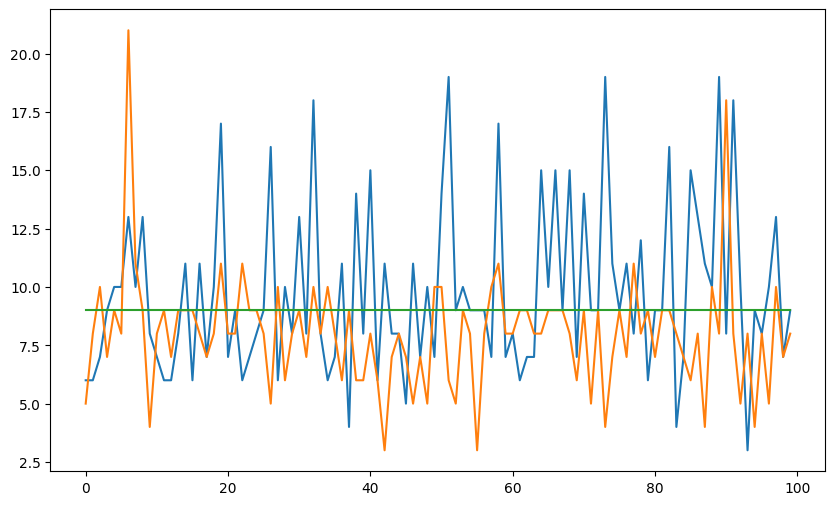

In [25]:
# importing package
import matplotlib.pyplot as plt

# These are far too large to display all results, so just plot a limited set.
sample = 100
x = [n for n in range(sample)]

plt.figure(figsize=(10, 6))

# plot line
plt.plot(x, pred1[:sample])
plt.plot(x, pred2[:sample])
plt.plot(x, pred3[:sample])
plt.show()

In [14]:
# FINAL_PREDICTION
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))
print(final_pred)

[6. 6. 7. ... 9. 9. 8.]


In [20]:
len(final_pred)

18123